In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import random
import numpy as np
from sympy import primerange
%matplotlib inline
from livelossplot import PlotLosses
from numba import jit, prange
import time

In [2]:
cities = pd.read_csv("dataset/cities.csv")

In [3]:
tour = pd.read_csv("submition_181206_v_1516768.4747805735.csv")['Path'].tolist()

In [4]:
tour[:15]

[0,
 78934,
 48816,
 40230,
 75405,
 153911,
 22121,
 38941,
 167366,
 177242,
 46360,
 114579,
 70519,
 139226,
 182992]

In [ ]:
random.shuffle(tour)

In [5]:
primes = list(primerange(0, len(cities)))

In [6]:
cities['prime'] = cities.CityId.isin(primes).astype(int)

In [7]:
cities.head()

,CityId,X,Y,prime
0,0,316.836739,2202.340707,0
1,1,4377.405972,336.602082,0
2,2,3454.158198,2820.053011,1
3,3,4688.099298,2935.898056,1
4,4,1010.696952,3236.750989,0


In [40]:
@jit
def score_tour(tour):
    # length of any given tour with primes calculation
    df = cities.reindex(np.array(tour + [0])).reset_index()
    df['prime'] = df.CityId.isin(primes).astype(int)
    df['dist'] = np.hypot(df.X - df.X.shift(-1), df.Y - df.Y.shift(-1))
    df['penalty'] = df['dist'][9::10] * (1 - df['prime'][9::10]) * 0.1
#     print(df.head(10))
    return df.dist.sum() + df.penalty.sum()

In [58]:
@jit(nopython=True, parallel=True)
def score_tour_numba(tour_, X, Y, primes):
    # length of any given tour with primes calculation
    full = 0.0
    for i in prange(0, len(tour_)-1):
        alpha = 1.0
        dst = np.hypot(X[tour_[i]] - X[tour_[i+1]], Y[tour_[i]] - Y[tour_[i+1]])
        if i%10 == 9 and primes[tour_[i]] == 0:
            alpha = 1.1
        full += alpha * dst
    return full

In [25]:
len(tour[:10])

10

In [64]:
start = time.time()
score_tour_numba(tour, cities.X.values, cities.Y.values, cities.prime.values)
end = time.time()
print(end - start)

0.02166914939880371


In [44]:
# start = time.time()
score_tour(tour)
# end = time.time()
# print(end - start)

0.09631872177124023


In [36]:
def local2op(path, i, k):
    tmp = path[i:k]
    return path[0:i] + tmp[::-1] + path[k:]

In [37]:
def swap(path, i, k):
    path[i], path[k] = path[k], path[i]
    return path

In [38]:
def ap(cnew, cold, T):
    return 1 / np.exp((cnew - cold) / T)

In [ ]:
%timeit local2op(tour.copy(), 3,5)

In [ ]:
print(1,2)

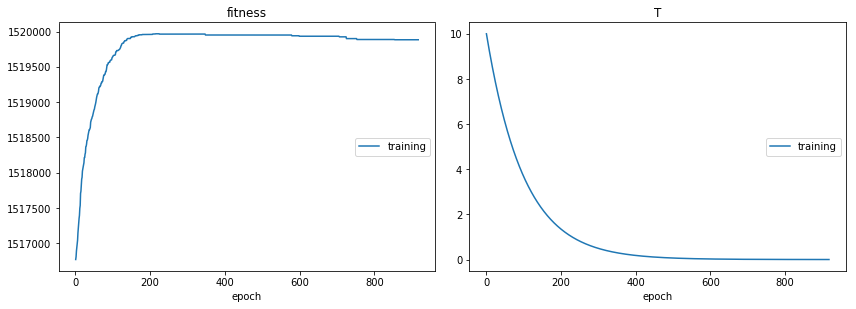

fitness:
training   (min: 1516768.475, max: 1519967.720, cur: 1519883.199)

T:
training   (min:    0.001, max:   10.000, cur:    0.001)


In [39]:
best_tour = score_tour_numba(tour, cities.X.values, cities.Y.values, cities.prime.values)
T = 10.0
T_min = 0.001
alpha = 0.99
tour_best = tour.copy()
liveplot = PlotLosses()

while T_min < T:
    liveplot.update({
                    'fitness': best_tour,
                    'T': T,
                })
    liveplot.draw()
    for i in range(100):
        a = random.randint(1, len(tour_best) - 20)
        b = random.randint(a+1, a+19)
        tour_tmp = swap(tour_best.copy(), a, b)
#         fitness_tmp = score_tour(tour_tmp)
        fitness_tmp = score_tour_numba(tour_tmp, cities.X.values, cities.Y.values, cities.prime.values)
        if fitness_tmp < best_tour:
            tour_best = tour_tmp
            pd.DataFrame({"Path": tour_best}).to_csv("submition_anneal_v_{}.csv".format(fitness_tmp), index=False)
            best_tour = fitness_tmp
        else:
            aprob = ap(fitness_tmp, best_tour, T)
            if random.uniform(0,1) <  aprob:
                tour_best = tour_tmp
                best_tour = fitness_tmp
    T = T*alpha